In [1]:
%matplotlib inline

In [2]:
import os
import json
from collections import namedtuple

import numpy as np
import torch
from nuscenes.prediction import convert_local_coords_to_global
from sklearn.cluster import AgglomerativeClustering

from datasets.nuscenes.dataset import NuscenesH5Dataset
from models.autobot_ego import AutoBotEgo
from process_args import get_eval_args

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.prediction.input_representation.static_layers import get_lanes_in_radius, StaticLayerRasterizer, correct_yaw
from nuscenes.prediction.helper import quaternion_yaw, convert_global_coords_to_local, make_2d_rotation_matrix, angle_of_rotation
from typing import Dict
from pyquaternion import Quaternion

In [4]:
def is_insquare(points, car_pos, ego_range):
    if (car_pos[0] - ego_range[0] < points[0] < car_pos[0] + ego_range[1]) and \
        (car_pos[1] - ego_range[2] < points[1] < car_pos[1] + ego_range[3]):
        return True
    return False

In [5]:
def distance(t1, t2) -> float:
    return math.sqrt((t1[0] - t2[0]) ** 2 + (t1[1] - t2[1]) ** 2)

In [6]:
def load_all_maps(helper: PredictHelper, verbose: bool = False) -> Dict[str, NuScenesMap]:
    """
    Loads all NuScenesMap instances for all available maps.
    :param helper: Instance of PredictHelper.
    :param verbose: Whether to print to stdout.
    :return: Mapping from map-name to the NuScenesMap api instance.
    """
    dataroot = helper.data.dataroot

    json_files = filter(
        lambda f: "json" in f and "prediction_scenes" not in f, os.listdir(os.path.join(dataroot, "maps", "expansion"))
    )
    maps = {}

    for map_file in json_files:

        map_name = str(map_file.split(".")[0])
        if verbose:
            print(f"static_layers.py - Loading Map: {map_name}")

        maps[map_name] = NuScenesMap(dataroot, map_name=map_name)

    return maps

In [7]:
def get_map_features(nusc_map, x, y, yaw, radius, reference_position=None, _max_number_roads=100, _number_future_road_points=40):
    curr_map = np.zeros((_max_number_roads, _number_future_road_points, 4))
    lanes = get_lanes_in_radius(x=x, y=y, radius=200, map_api=nusc_map, discretization_meters=2.0)

    # need to combine lanes that are connected to avoid random gaps.
    combined_lane_ids = []  # list of connected lane ids.
    ignore_lane_ids = []  # List of lane ids to ignore because they are connected to prior lane ids.
    for lane_id in lanes.keys():
        if lane_id in ignore_lane_ids:
            continue
        curr_lane_ids = [lane_id]
        out_lane_ids = nusc_map.get_outgoing_lane_ids(lane_id)
        for out_lane_id in out_lane_ids:
            if out_lane_id in lanes.keys():
                curr_lane_ids.append(out_lane_id)
                ignore_lane_ids.append(out_lane_id)

                outout_lane_ids = nusc_map.get_outgoing_lane_ids(out_lane_id)
                for outout_lane_id in outout_lane_ids:
                    if outout_lane_id in lanes.keys():
                        curr_lane_ids.append(outout_lane_id)
                        ignore_lane_ids.append(outout_lane_id)

        combined_lane_ids.append(curr_lane_ids)

    relevant_pts = []
    for i in range(len(combined_lane_ids)):
        for lane_id in combined_lane_ids[i]:
            pts = lanes[lane_id]
            road_pts = []
            for pt in pts:
                pt = list(pt)
                pt.append(1.0)
                pt = np.array(pt)
                road_pts.append(pt)
            if len(road_pts) > 0:
                relevant_pts.append(np.array(road_pts))

    # relevant_pts is a list of lists, which each sublist containing the points on a road in the fov.
    if len(relevant_pts) > 0:
        # relevant_pts is a list of arrays each with [numb_pts, 3]
        # need to sort each one according to its closeness to the agent position
        first_pts = []
        for i in range(len(relevant_pts)):
            indices = np.argsort(np.linalg.norm(np.array([[x, y]]) - relevant_pts[i][:, :2], axis=1))
            relevant_pts[i] = relevant_pts[i][indices]
            first_pts.append(relevant_pts[i][0])

        # sort using the first point of each road
        first_pts = np.array(first_pts)
        indices = np.argsort(np.linalg.norm(np.array([[x, y]]) - first_pts[:, :2], axis=1)).tolist()
        mymap = np.array(relevant_pts, dtype=object)[indices[:_max_number_roads]]
        for i in range(min(len(mymap), _max_number_roads)):
            curr_map[i, :min(len(mymap[i]), _number_future_road_points)] = \
                mymap[i][:min(len(mymap[i]), _number_future_road_points)]
    else:
        raise Exception("Did not find any lanes in the map...")
    return curr_map

In [8]:
def convert_coordinates_to_ego(points, ego_rotation, ego_translation):
    rotated_points = convert_global_coords_to_local(points, 
                                                    ego_translation, 
                                                    ego_rotation)
    return rotated_points

In [9]:
def get_box_points(width, length, instance_translation, instance_rotation):
    center = np.array([0, 0])
    upper_right_corner = np.array([width/2, length/2])
    upper_left_corner = np.array([-width/2, length/2])
    lower_right_corner = np.array([-width/2, -length/2])
    lower_left_corner = np.array([width/2, -length/2])
    points = np.vstack([center, upper_right_corner, upper_left_corner, 
                      lower_right_corner, lower_left_corner])
    return convert_local_coords_to_global(points, 
                                          instance_translation, 
                                          instance_rotation)

In [38]:
def filter_construction_objects(sample_token):
    object_points = []
    sample_info = nusc.get('sample', sample_token)
    construction_flag = False
    for instance_token in sample_info['anns']:
        instance = nusc.get('sample_annotation', instance_token)
        if instance['category_name'] in ["movable_object.barrier", 
                                         "movable_object.trafficcone"]:
            
            width, length, _ = instance['size']
            points = get_box_points(width, length, instance['translation'], instance['rotation'])
            
            ego_translation = ego_vehicle['translation']
            ego_rotation = ego_vehicle['rotation']
            
            rotated_points = convert_coordinates_to_ego(points, 
                                                        ego_rotation, 
                                                        ego_translation)
            if is_insquare(rotated_points[0], [0., 0.], ego_range):
                augmented_points = np.hstack([rotated_points, 
                                              (instance['translation'][-1]-ego_vehicle['translation'][-1])*np.ones((5,1)), 
                                              np.ones((5,1))])
                
                object_points.append(np.vstack([augmented_points, np.zeros((35, 4))]))
                construction_flag = True
                
    object_points = np.array(object_points)
    if object_points.shape[0] == 0:
        return np.zeros((50,40,4))
    indices = np.argsort(np.linalg.norm(object_points[:,0,:], axis=1)).tolist()   
    object_points = object_points[indices]
    n_objs, _, _ = object_points.shape
    
    if n_objs >= 50:
        return object_points[:50,:,:], construction_flag
    else:
        return np.vstack([object_points, np.zeros((50-n_objs,40,4))]), construction_flag

In [11]:
from nuscenes.nuscenes import NuScenes

DATAROOT = '/home/juan/Documents/trajectory_prediction/datasets/nuscenes/v1.0-trainval_full/'
VERSION = 'v1.0-trainval'
nusc = NuScenes(VERSION, dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 18.274 seconds.
Reverse indexing ...
Done reverse indexing in 3.9 seconds.


In [12]:
_helper = PredictHelper(nusc)

In [13]:
_map_dict = load_all_maps(_helper, verbose=True)

static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: singapore-queenstown


In [14]:
#sample_token = "ad9a4ac746ed482d9011da67b95d0364"
#sample_token = "0c7b724903d145549281eb79c236e0ba"
sample_token = "ca7bd3e7bf664a1aa2a4a06858285ed6"
#sample_token = "f017adc5c691441c8a1d218e38551501"
#sample_token = "0466f5710063461b92556fb2d6767980"
#sample_token = "4796e86af90c4ff4bef41ecb11bb280d"
#sample_token = "8613eaa60fdb40e7b7564f4bd1a0a713"

#sample_token = "9aa4c454c6154c069354edd8819f767a"

In [15]:
map_name = _helper.get_map_name_from_sample_token(sample_token)

'singapore-onenorth'

In [24]:
_map_dict = load_all_maps(_helper, verbose=True)

static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: singapore-queenstown


In [16]:
sample_info = nusc.get('sample', sample_token)

In [17]:
first_car = True
for instance_token in sample_info["anns"]:
    instance = nusc.get('sample_annotation', instance_token)
    #print(instance['category_name'])
    if instance['category_name'] == "vehicle.car" and first_car:
        first_car = False
        ego_token = instance_token

In [18]:
ego_vehicle = nusc.get('sample_annotation', ego_token)

In [19]:
quaternion_yaw(Quaternion(ego_vehicle['rotation']))

-1.9532852323703234

In [20]:
theta = correct_yaw(quaternion_yaw(Quaternion(ego_vehicle['rotation'])))
theta

-1.1883074212194698

In [22]:
x, y = ego_vehicle["translation"][0], ego_vehicle["translation"][1]

In [25]:
curr_map = get_map_features(_map_dict[map_name], 
                            x, 
                            y, 
                            theta, 
                            radius=200, 
                            reference_position=None, 
                            _max_number_roads=max_number_roads, 
                            _number_future_road_points=number_future_road_points)

In [26]:
rotated_map = np.zeros_like(curr_map)
for road_idx in range(len(curr_map)):
    for pt_idx in range(len(curr_map[road_idx])):
        if curr_map[road_idx, pt_idx, -1] == 1:
            rotated_pt = convert_global_coords_to_local(curr_map[road_idx, pt_idx, :2], ego_vehicle['translation'],
                                                        ego_vehicle['rotation'])
            #print(rotated_pt)
            if is_insquare(rotated_pt[0], [0., 0.], ego_range):
                rotated_map[road_idx, pt_idx, :2] = rotated_pt
                rotated_map[road_idx, pt_idx, 2] = theta - curr_map[road_idx, pt_idx, 2]
                rotated_map[road_idx, pt_idx, -1] = 1

In [27]:
rotated_map.shape

(100, 40, 4)

In [28]:
map_x = [point[0] for segment in rotated_map for point in segment]
map_y = [point[1] for segment in rotated_map for point in segment]
map_z = [point[2] for segment in rotated_map for point in segment]

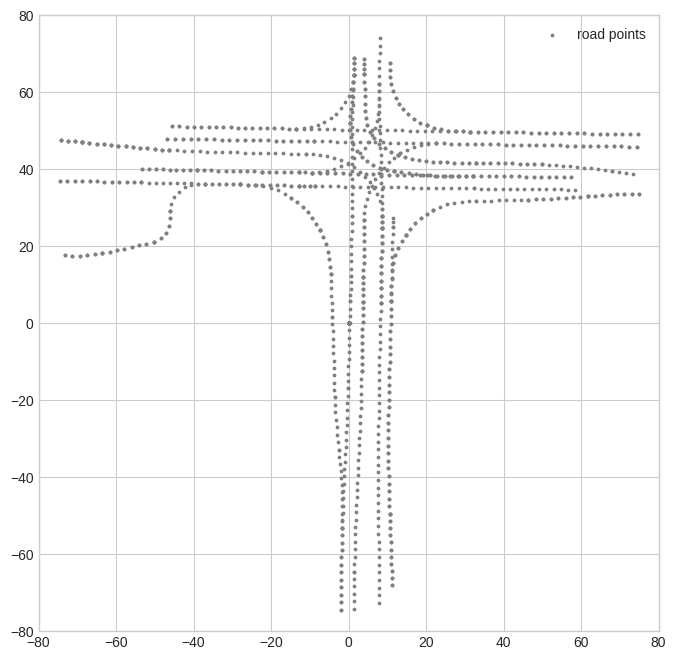

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(map_x, map_y, s=3, color="gray", label="road points")
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend()

In [32]:
objects = filter_construction_objects(sample_token)

In [36]:
objects_x = [point[0] for object_i in objects for point in object_i]
objects_y = [point[1] for object_i in objects for point in object_i]

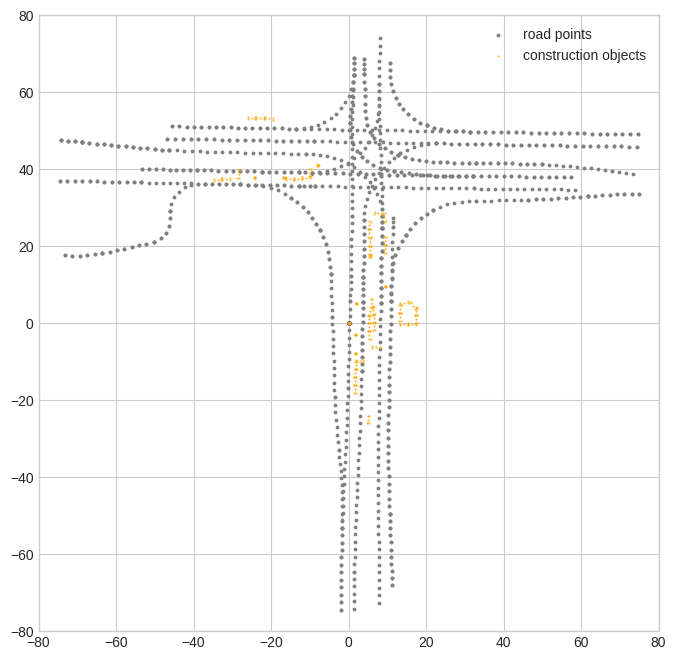

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(map_x, map_y, s=3, color="gray", label="road points")
plt.scatter(objects_x, objects_y, s=0.2, color="orange", label="construction objects")
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend()

In [44]:
from datasets.nuscenes.raw_dataset import NuScenesDataset

In [47]:
max_num_agents = 20

In [48]:
nuscenes = NuScenesDataset(data_root=DATAROOT, split_name='val',
                               version='v1.0-trainval', ego_range=ego_range, num_others=max_num_agents)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 18.666 seconds.
Reverse indexing ...
Done reverse indexing in 4.1 seconds.
static_layers.py - Loading Map: singapore-hollandvillage
static_layers.py - Loading Map: boston-seaport
static_layers.py - Loading Map: singapore-onenorth
static_layers.py - Loading Map: singapore-queenstown


In [ ]:
def count_
    _map_dict = load_all_maps(_helper, verbose=True)